In [1]:
import numpy as np
from os.path import expanduser
import os
import json
import theano
import pyret.filtertools as ft
import pyret.visualizations as pyviz
#import deepretina.visualizations as viz
import preprocessing
from preprocessing import datagen, loadexpt
from utils import rolling_window
from keras.models import model_from_json
import h5py
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
%matplotlib inline
#%matplotlib qt

from pylab import rcParams
rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

Using gpu device 0: GeForce GT 750M (CNMeM is disabled)
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Load full STC of the experiment  
This is the normalized STC with (STA)(STA)^T subtracted

In [2]:
path_to_stc = '/Users/lmcintosh/Dropbox/deep-retina/saved/lenna.salamander/2015-12-04 10.26.59 Experiment STC/'
stc_filename = 'full_stc_experiment_15_10_07.h5'
f = h5py.File(os.path.join(path_to_stc, stc_filename), 'r')

In [3]:
list(f)

[u'stc']

In [4]:
stc = f['stc']

In [5]:
stc.shape

(4235, 4235)

In [6]:
u,v = np.linalg.eigh(stc)

In [7]:
(u.shape, v.shape)

((4235,), (4235, 4235))

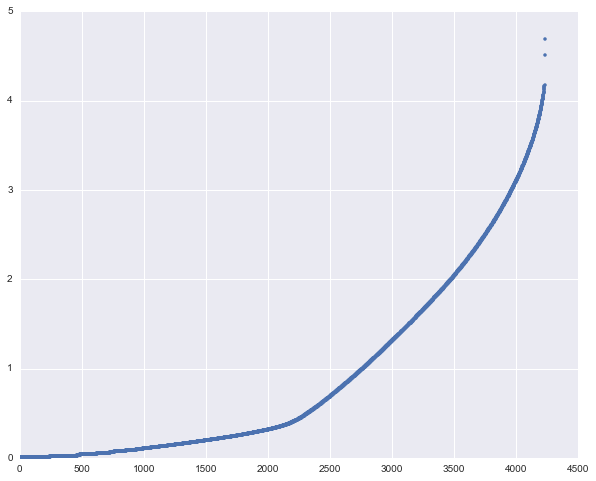

In [9]:
plt.plot(u, '.')

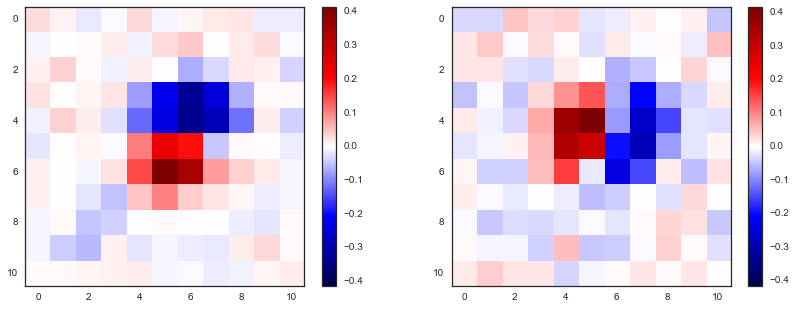

In [33]:
fig = plt.gcf()
fig.set_size_inches((14,5))
plt.subplot(1,2,1)
space, time = ft.decompose(v[:,-1].reshape((35,11,11)))
plt.imshow(space, interpolation='nearest', cmap='seismic', clim=[-np.max(np.abs(space)), np.max(np.abs(space))])
plt.colorbar()

plt.subplot(1,2,2)
space, time = ft.decompose(v[:,-2].reshape((35,11,11)))
plt.imshow(space, interpolation='nearest', cmap='seismic', clim=[-np.max(np.abs(space)), np.max(np.abs(space))])
plt.colorbar()

# Compute STC of CNN

In [2]:
# whitenoise_train_unrolled = loadexpt(0, 'whitenoise', 'train', 40, roll=False)
whitenoise_train_rolled = loadexpt(0, 'whitenoise', 'train', 40, roll=True)

Loading training data... Done.


In [3]:
architecture_filename = 'architecture.json'
whitenoise_data_dir = '/Users/lmcintosh/Dropbox/deep-retina/saved/lenna.salamander/2015-11-08 15.42.33 convnet/'
whitenoise_weight_filename = 'epoch018_iter01300_weights.h5' # .63 cc on held-out

whitenoise_architecture_data = open(whitenoise_data_dir + architecture_filename, 'r')
whitenoise_architecture_string = whitenoise_architecture_data.read()
whitenoise_model = model_from_json(whitenoise_architecture_string)
whitenoise_model.load_weights(whitenoise_data_dir + whitenoise_weight_filename)

In [4]:
whitenoise_train_rolled.X.shape

(359762, 40, 50, 50)

In [5]:
np.mean(whitenoise_train_rolled.y)

7.1536721965425132

In [6]:
np.std(whitenoise_train_rolled.y)

17.963241871749414

### True firing rate of the cell is:

In [7]:
100 * (25761./whitenoise_train_rolled.y.shape[0])

7.160567263913364

### Get model predictions

In [8]:
whitenoise_train_rolled[0][:5].shape

(5, 40, 50, 50)

In [9]:
num_examples = whitenoise_train_rolled.X.shape[0]
first_in_batch = range(0,num_examples,50)

In [13]:
model_predictions = []
for ind in first_in_batch:
    preds = whitenoise_model.predict_on_batch(whitenoise_train_rolled.X[ind:ind+50])
    model_predictions.extend(preds)

In [14]:
len(model_predictions)

359762

In [15]:
whitenoise_train_rolled[0].shape

(359762, 40, 50, 50)

In [16]:
pwd

u'/Users/lmcintosh/Git/deep-retina/notebooks'

In [17]:
g = h5py.File('model_predictions.h5', 'w')
g.create_dataset('predictions', data=model_predictions)
g.close()

### Threshold model predictions to get "spikes"

In [19]:
model_spikes = np.where(model_predictions > 2.39*np.std(model_predictions), 1, 0)

In [20]:
np.sum(model_spikes)

25799

In [21]:
100. * (1.*np.sum(model_spikes)/whitenoise_train_rolled.X.shape[0])

7.171129802480529

In [22]:
len(model_spikes)

359762

### Load real times of stimulus and get time stamps of model spikes

In [23]:
f = h5py.File(os.path.join(preprocessing.datadirs['lane.local'], '15-10-07/whitenoise.h5'), 'r')

In [24]:
f['train/time'].shape

(359802,)

In [25]:
time = np.array(f['train/time'][40:])

In [26]:
time.shape

(359762,)

In [43]:
# model_spike_times = np.where(model_predictions > 2.39*np.std(model_predictions), time, -1)
model_spike_times = time[model_spikes.flatten().astype('bool')]

In [44]:
len(model_spike_times)

25799

In [45]:
model_spike_times[:10]

array([ 0.43029667,  0.44030333,  0.45031   ,  0.55038333,  0.56038667,
        0.57039   ,  0.58039667,  0.59040333,  0.60041   ,  0.76052667])

### Now get unrolled stimulus

In [48]:
del whitenoise_train_rolled

In [49]:
whitenoise_train_unrolled = loadexpt(0, 'whitenoise', 'train', 40, roll=False)

Loading training data... Done.


In [50]:
time.shape

(359762,)

In [51]:
whitenoise_train_unrolled.X[40:].shape

(359762, 50, 50)

In [52]:
sta, tax = ft.getsta(time, whitenoise_train_unrolled.X[40:], model_spike_times, 35)

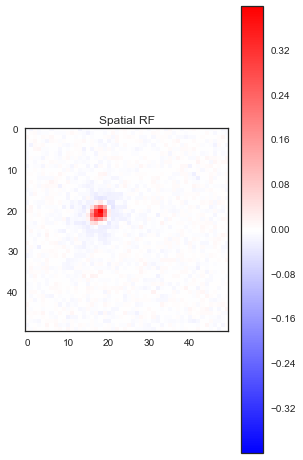

(<matplotlib.figure.Figure at 0x119192290>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x118068710>,
  <matplotlib.axes._subplots.AxesSubplot at 0x113c8c190>))

In [53]:
pyviz.plotsta(tax, sta)

# Reduce dimensionality of STC by cutting out a window around the RF

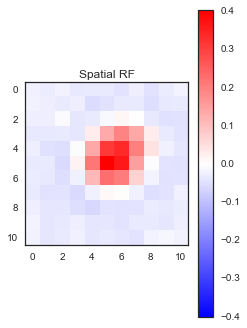

(<matplotlib.figure.Figure at 0x11918ec90>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x11e20b4d0>,
  <matplotlib.axes._subplots.AxesSubplot at 0x11e21d950>))

In [54]:
pyviz.plotsta(tax, ft.cutout(sta, idx=np.flipud(ft.filterpeak(sta)[1]), width=5))

In [57]:
Xcut = ft.cutout(whitenoise_train_unrolled.X[40:], idx=np.flipud(ft.filterpeak(sta)[1]), width=5)

In [58]:
Xcut.shape

(359762, 11, 11)

In [59]:
Xcut.dtype

dtype('float32')

In [60]:
sta_cut = ft.cutout(sta, idx=np.flipud(ft.filterpeak(sta)[1]), width=5)

In [61]:
sta_cut.shape

(35, 11, 11)

# Do STC

In [ ]:
stc = np.zeros((35*11*11, 35*11*11))
for idx, s in enumerate(ft.getste(time, Xcut, model_spike_times, 35)):
    sr = s.astype('float').ravel()
    if sr.size == (35*11*11):
        stc += np.outer(sr, sr)
        
    if idx % 500 == 0:
        print('{}'.format(100.*idx/len(spk)))

In [ ]:
stc_normalized = stc/len(spk)
stc_normalized -= np.outer(sta_cut.ravel(), sta_cut.ravel())

# Load STC from file

In [68]:
path_to_stc = '/Users/lmcintosh/Dropbox/deep-retina/saved/lenna.salamander/2015-12-07 12.16.59 Convnet STC/'
stc_filename = 'full_stc_convnet_15_10_07.h5'
h = h5py.File(os.path.join(path_to_stc, stc_filename), 'r')

In [69]:
stc = h['stc']

In [70]:
stc.shape

(4235, 4235)

In [71]:
u,v = np.linalg.eigh(stc)

In [72]:
(u.shape, v.shape)

((4235,), (4235, 4235))

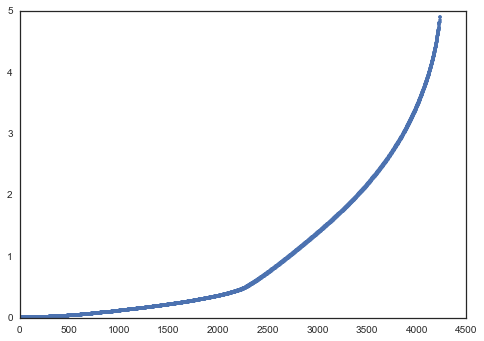

In [73]:
plt.plot(u, '.')

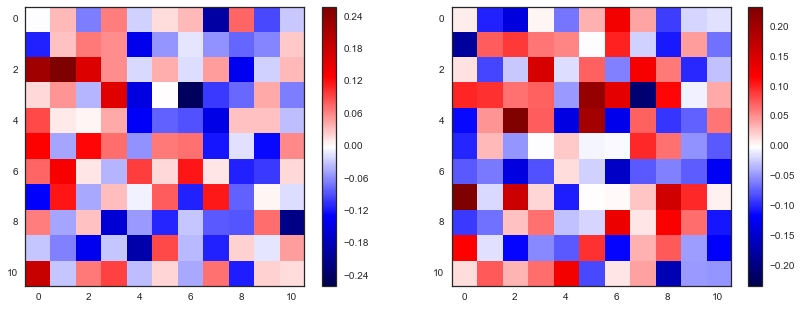

In [74]:
fig = plt.gcf()
fig.set_size_inches((14,5))
plt.subplot(1,2,1)
space, time = ft.decompose(v[:,-1].reshape((35,11,11)))
plt.imshow(space, interpolation='nearest', cmap='seismic', clim=[-np.max(np.abs(space)), np.max(np.abs(space))])
plt.colorbar()

plt.subplot(1,2,2)
space, time = ft.decompose(v[:,-2].reshape((35,11,11)))
plt.imshow(space, interpolation='nearest', cmap='seismic', clim=[-np.max(np.abs(space)), np.max(np.abs(space))])
plt.colorbar()

# Analytic STC

In [77]:
import theano.tensor as T

In [76]:
theano_model = theano.function([whitenoise_model.layers[0].input], whitenoise_model.layers[-1].get_output(train=False))

In [94]:
# x = T.tensor3('x', dtype='float32')
# dmodel = T.grad(theano_model, x)
# dmodel = T.grad(theano_model, whitenoise_model.layers[0].input)
# dmodel = T.grad(theano_model, [np.random.randn(5,40,50,50).astype('float32')])

AttributeError: 'Function' object has no attribute 'type'

In [82]:
theano_model(np.random.randn(5,40,50,50).astype('float32'))

array([[ 0.23398365],
       [ 0.11231275],
       [ 0.0312001 ],
       [ 0.40517908],
       [ 0.68123859]], dtype=float32)

In [100]:
theano_model

In [102]:
dmodel = T.grad(whitenoise_model.layers[-1].get_output(train=False), whitenoise_model.layers[0].input)

TypeError: cost must be a scalar.

In [103]:
whitenoise_model.layers[-1].get_output(train=False)

softplus.0

In [107]:
type(whitenoise_model.layers[-1].get_output())

theano.tensor.var.TensorVariable